# Creating New Models

In this notebook, we will walk through an example of how to create a new model using the `prfmodel` package.

Before we get started, we need to install the `prfmodel` package from 
[GitHub](https://github.com/popylar-org/prfmodel). The package is still in its early stages and, while the general
architecture of the package will likely stay the same, the API will probably undergo many changes. Nevertheless, we
will try to keep this notebook up to date. At some point, we might integrate it into the package itself.

We install the package from the `add-sgd-fitter` branch to include latest model fitting implementations. We also
install `tensorflow` to be used as the backend and `matplotlib` for plotting.

In [1]:
!pip install git+https://github.com/popylar-org/prfmodel@add-sgd-fitter tensorflow matplotlib

  Cloning https://github.com/popylar-org/prfmodel (to revision add-sgd-fitter) to /tmp/pip-req-build-j9_b3m5r
  Running command git clone --filter=blob:none --quiet https://github.com/popylar-org/prfmodel /tmp/pip-req-build-j9_b3m5r
  Running command git checkout -b add-sgd-fitter --track origin/add-sgd-fitter
  Running command git checkout -b add-sgd-fitter --track origin/add-sgd-fitter
  Switched to a new branch 'add-sgd-fitter'
  branch 'add-sgd-fitter' set up to track 'origin/add-sgd-fitter'.
  Resolved https://github.com/popylar-org/prfmodel to commit 156cc3b7ebc7ad1d996591db6ff8ec333313a985
  Installing build dependencies ...   Switched to a new branch 'add-sgd-fitter'
  branch 'add-sgd-fitter' set up to track 'origin/add-sgd-fitter'.
  Resolved https://github.com/popylar-org/prfmodel to commit 156cc3b7ebc7ad1d996591db6ff8ec333313a985
  Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... -done
  Preparing

Let's start with the context and setup of our new model. We have observed response timeseries (e.g., neural responses) 
for multiple sources (e.g., voxels). We want to model these responses as linear functions of a 1D 'target' stimulus
(e.g., numerosity). We also want to include a set of linear binary covariates. The goal is to estimate the slopes
for the target stimulus, the covariates, as well as an intercept (i.e., the baseline) for each source. The estimation
will be done with least squares.

In [31]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import ops

from prfmodel.fitters.linear import LeastSquaresHistory
from prfmodel.fitters.sgd import SGDFitter
from prfmodel.models.base import BasePRFResponse, BasePRFModel, BaseTemporal
from prfmodel.models.impulse import TwoGammaImpulse, convolve_prf_impulse_response
from prfmodel.models.temporal import BaselineAmplitude
from prfmodel.utils import convert_parameters_to_tensor, get_dtype

Because the default `prfmodel.stimulus.Stimulus` class does not yet allow for covariates, we create our own stimulus
class that acts as a container for our target stimulus and the covariate values for a number of time frames.

In [3]:
class CovariateStimulus:
    def __init__(self, target: np.ndarray, covariates: np.ndarray):
        self.target = target
        self.covariates = covariates

Let's create a normally distributed target and binary covariates and store them in our stimulus class object.

In [4]:
# For reproducibility
rng = np.random.default_rng(2025)

num_frames = 100 # time frames
num_covariates = 4

target = rng.choice(np.arange(-5, 5), size=num_frames)
covariates = rng.binomial(1, 0.5, size=(num_frames, num_covariates))

stimulus = CovariateStimulus(target=target, covariates=covariates)

print(target.shape, covariates.shape)

(100,) (100, 4)


Now, we start defining our new model. In `prfmodel`, models are constructed using different submodel classes that
perform specific computations. These submodels are then combined using a composite model class that defines how the
submodels interact with each other to produce a combined output. In general, all model classes in `prfmodel` require
a `parameter_names` property that defines the parameters that the model acceps as well as a `__call__` method that
defines how the model makes predictions given some input and the required parameters.

In `prfmodel`, there currently is no submodel class that predicts a linear combination of covariates, so we create our
own called `LinearCovariates`. We define the `parameter_names` property to specify which parameters our model requires,
namely, a slope (`amplitude`) for each covariate. Then, we define the `__call__` method which implements the model prediction. The prediction is a linear combination
of our parameters and the covariates.

In [5]:
class LinearCovariates(BaseTemporal):
    def __init__(self, num_covariates: int):
        super().__init__()
        self.num_covariates = num_covariates

    @property
    def parameter_names(self):
        # We need a slope parameter for each covariate
        return [f"amplitude_covariate_{i}" for i in range(self.num_covariates)]
    
    def __call__(self, inputs: np.ndarray, covariates: np.ndarray, parameters: pd.DataFrame, dtype = None):
        dtype = get_dtype(dtype)
        inputs = ops.convert_to_tensor(inputs, dtype=dtype)
        covariates = ops.convert_to_tensor(covariates, dtype=dtype)
        # Convert the parameters to tensors
        slope_covariates = convert_parameters_to_tensor(
            parameters[[f"amplitude_covariate_{i}" for i in range(self.num_covariates)]], dtype
        )

        # Matrix multiplication between slopes and covariates = linear combination
        cov_matmul = slope_covariates @ ops.transpose(covariates)

        return inputs + cov_matmul

Now, we define a new composite model class called `LinearEncodingModel` that combines our submodel class with two
submodel classes that already
exist in `prfmodel`: The `BaselineAmplitude` class which scales and shifts our target using a `baseline` and
`amplitude` parameter and the `TwoGammaImpulse` class which we use to convolve our linear response with an impulse
response. The impulse response is the weighted difference between two gamma densities. See the documentation of
`TwoGammaImpulse` for more details.

In our composite model class, we define the `__call__` method that specifies that we first shift and scale the
target stimulus with our `BaselineAmplitude` model, then we add the linear combination of covariates, and finally we
convolve the result with the impulse response. Note that we don't define the `parameter_names` property for this class,
instead it will collect all the `parameter_names` of its submodel classes.

In [6]:
class LinearEncodingModel(BasePRFModel):
    def __init__(
            self,
            response_model=None,
            covariate_model=None,
            impulse_model=None,
        ):

        if response_model is None:
            response_model = BaselineAmplitude()

        super().__init__(
            response_model=response_model,
            covariate_model=covariate_model,
            impulse_model=impulse_model,
        )

    def __call__(self, stimulus, parameters, dtype = None):
        dtype = get_dtype(dtype)

        response = ops.expand_dims(ops.convert_to_tensor(stimulus.target), 0)

        if self.models["response_model"] is not None:
            response_model = self.models["response_model"]
            response = response_model(response, parameters, dtype=dtype)

        if self.models["covariate_model"] is not None:
            covariate_model = self.models["covariate_model"]
            covariates = ops.convert_to_tensor(stimulus.covariates, dtype=dtype)
            response = covariate_model(response, covariates, parameters, dtype=dtype)

        if self.models["impulse_model"] is not None:
            impulse_model = self.models["impulse_model"]
            impulse_response = impulse_model(parameters, dtype=dtype)
            response = convolve_prf_impulse_response(response, impulse_response)

        return response


We instantiate our composite model with the respective submodels. Note that we can also swap out each submodel as long
as the input and output have the same shape. Within the `LinearCovaraites` class, we specify the number of covariates
defined earlier.

In [23]:
model = LinearEncodingModel(
    response_model=BaselineAmplitude(),
    covariate_model=LinearCovariates(num_covariates),
    impulse_model=TwoGammaImpulse(),
)

Next, we use the composite model to make predictions. To do that, we define a number of sources for which to make predictions
and the parameters for each source.

In [24]:
num_sources = 20

# These names need to match the parameter names required by our model
parameters = pd.DataFrame({
    "baseline": rng.normal(size=num_sources),
    "amplitude": rng.normal(size=num_sources),
    "amplitude_covariate_0": rng.normal(size=num_sources, loc=5.0, scale=0.1),
    "amplitude_covariate_1": rng.normal(size=num_sources, loc=-5.0, scale=1.0),
    "amplitude_covariate_2": rng.normal(size=num_sources, loc=0.0, scale=1.0),
    "amplitude_covariate_3": rng.normal(size=num_sources, loc=0.0, scale=10.0),
    "shape_1": [6.0] * num_sources,
    "rate_1": [0.9] * num_sources,
    "shape_2": [12.0] * num_sources,
    "rate_2": [0.9] * num_sources,
    "weight": [0.35] * num_sources,
})
# We transform the predicted response back to numpy.array to make plotting easier
resp = np.asarray(model(stimulus, parameters))

We can plot the predicted response timeseries for each source.

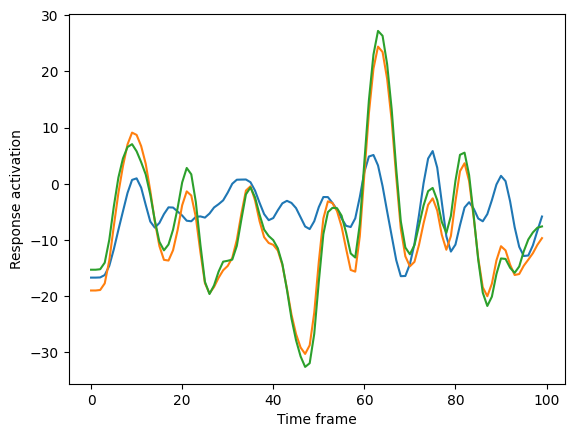

In [25]:
num_to_plot = 3

fig, ax = plt.subplots()

ax.plot(resp.T[:, :num_to_plot])
ax.set_xlabel("Time frame")
ax.set_ylabel("Response activation")

_ = plt.show()

Now, we estimate the model parameters by fitting the model back to the predicted response. We use least squares
to fit the model to each source. Least squares fitting with covariates is not yet implemented in `prfmodel`, so we
define our own fitter class.

In [26]:
class LeastSquaresCovariatesFitter:
    def __init__(
        self,
        model,
        stimulus,
        dtype=None,
    ):
        self.model = model
        self.stimulus = stimulus
        self.dtype = get_dtype(dtype)

    def fit(
        self,
        data,
        parameters,
        target_parameters,
    ):
        # Convert everything to keras tensor with the same dtype
        data = ops.convert_to_tensor(data, dtype=self.dtype)
        target = ops.expand_dims(ops.convert_to_tensor(self.stimulus.target, dtype=self.dtype), 1)
        covariates = ops.convert_to_tensor(self.stimulus.covariates, dtype=self.dtype)
        # Add ones for intercept
        intercept = ops.ones((target.shape[0], 1), dtype=self.dtype)

        # Combine all x variables into matrix
        x_matrix = ops.tile(
            ops.concatenate([
                intercept,
                target,
                covariates
            ], axis=1),
            (data.shape[0], 1, 1)
        )

        data = ops.expand_dims(data, axis=-1)

        # Solve least squares for each source
        best_params = keras.ops.map(lambda x: keras.ops.lstsq(x[0], x[1]), (x_matrix, data))

        # Calc residual sum of squares for each source
        residual_sum = ops.convert_to_numpy(ops.sum(ops.square(data - x_matrix @ best_params), axis=(-2, -1)))

        # Return parameters as dataframe
        new_parameters = parameters.copy()

        new_parameters[target_parameters] = ops.convert_to_numpy(best_params[..., 0])

        return LeastSquaresHistory({"loss": residual_sum}), new_parameters

We instantiate the fitter class and fit our new model to its own response. Can we recover the original prediction
parameters?

In [27]:
ls_fitter = LeastSquaresCovariatesFitter(
    model=model,
    stimulus=stimulus,
)

ls_history, ls_params = ls_fitter.fit(
    resp,
    parameters=parameters,
    target_parameters=["baseline", "amplitude", "amplitude_covariate_0", "amplitude_covariate_1", "amplitude_covariate_2", "amplitude_covariate_3"]
)
ls_params.iloc[:num_to_plot]

,baseline,amplitude,amplitude_covariate_0,amplitude_covariate_1,amplitude_covariate_2,amplitude_covariate_3,shape_1,rate_1,shape_2,rate_2,weight
0,-4.984810,0.079760,-1.253388,1.581543,-1.116879,0.239767,6.0,0.9,12.0,0.9,0.35
1,-9.036777,0.263269,-2.646611,2.965451,1.058639,0.224823,6.0,0.9,12.0,0.9,0.35
2,-8.041315,0.417789,-2.734381,2.738363,1.503712,0.279108,6.0,0.9,12.0,0.9,0.35


In [28]:
parameters.iloc[:num_to_plot]

,baseline,amplitude,amplitude_covariate_0,amplitude_covariate_1,amplitude_covariate_2,amplitude_covariate_3,shape_1,rate_1,shape_2,rate_2,weight
0,0.184150,0.097230,4.938329,-5.545685,-1.699239,-1.394849,6.0,0.9,12.0,0.9,0.35
1,0.960947,1.451281,5.053274,-5.717524,-1.105937,-4.550084,6.0,0.9,12.0,0.9,0.35
2,1.031080,1.553142,4.991356,-4.477974,0.016459,-6.238030,6.0,0.9,12.0,0.9,0.35


Using the estimated parameters, can we create model new predictions that are close to the original timeseries?

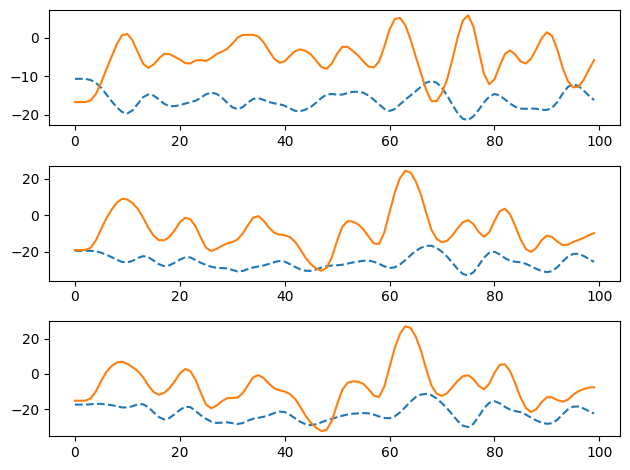

In [ ]:
ls_resp_predicted = np.asarray(model(stimulus, ls_params))

fig, axarr = plt.subplots(num_to_plot, 1)

for i, ax in enumerate(axarr.flatten()):
    ax.plot(ls_resp_predicted[i, :], "--")
    ax.plot(resp[i, :])

fig.tight_layout()

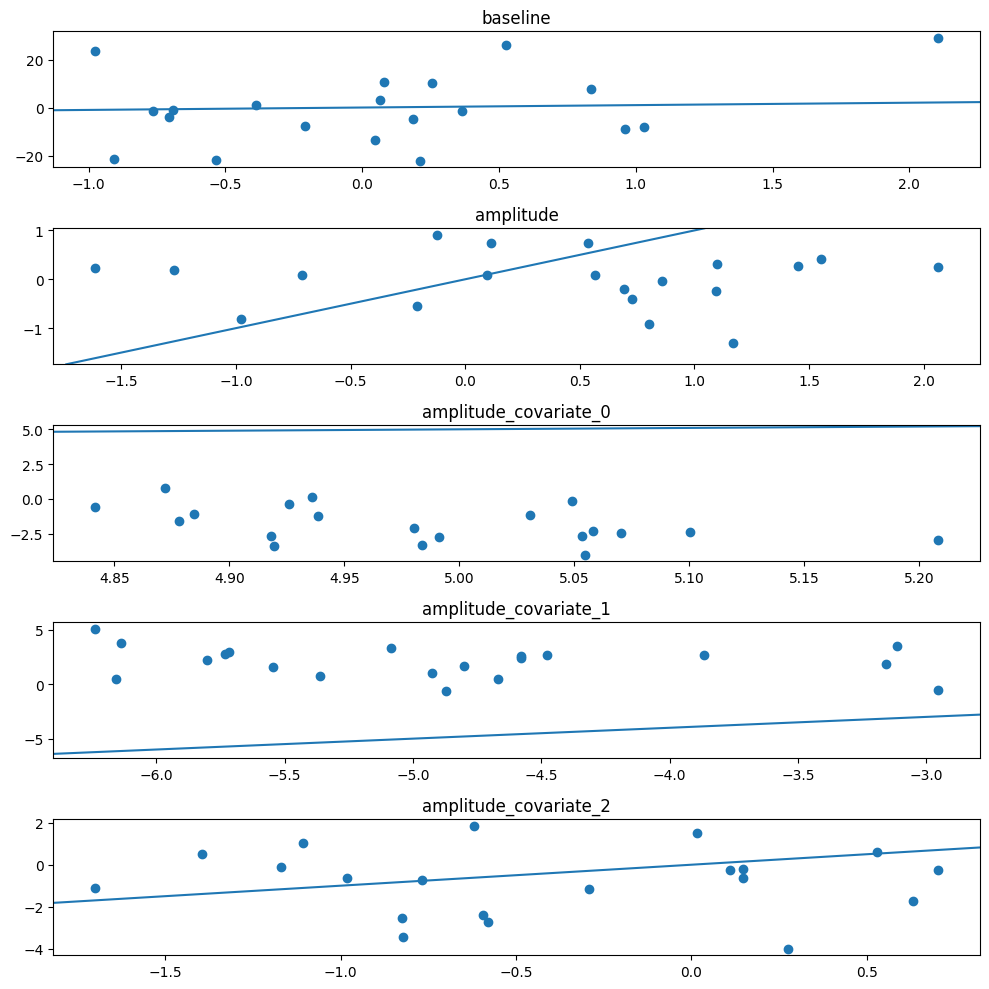

In [30]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

for ax, col in zip(ax.flatten(), parameters.columns[:5], strict=False):
    true_vals = parameters[col]
    est_vals = ls_params[col]
    ax.scatter(true_vals, est_vals)
    ax.axline(xy1=(true_vals.min(), true_vals.min()), slope=1)
    ax.set_title(col)

fig.tight_layout()

The parameters and timeseries responses estimated by our least squares fitter are not very good. We can also try
estimating them with stochastic gradient descent.

In [35]:
sgd_fitter = SGDFitter(
    model=model,
    stimulus=stimulus,
)

sgd_history, sgd_params = sgd_fitter.fit(resp, ls_params, fixed_parameters=["shape_1", "rate_1", "shape_2", "rate_2", "weight"])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:26<00:00, 38.14it/s, loss=865]   


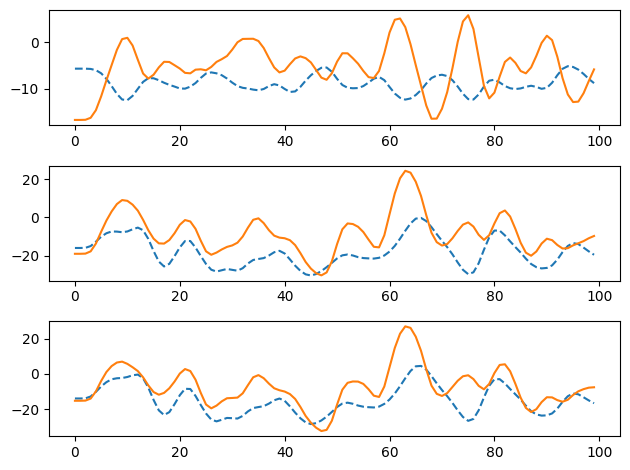

In [36]:
sgd_resp_predicted = np.asarray(model(stimulus, sgd_params))

fig, axarr = plt.subplots(num_to_plot, 1)

for i, ax in enumerate(axarr.flatten()):
    ax.plot(sgd_resp_predicted[i, :], "--")
    ax.plot(resp[i, :])

fig.tight_layout()

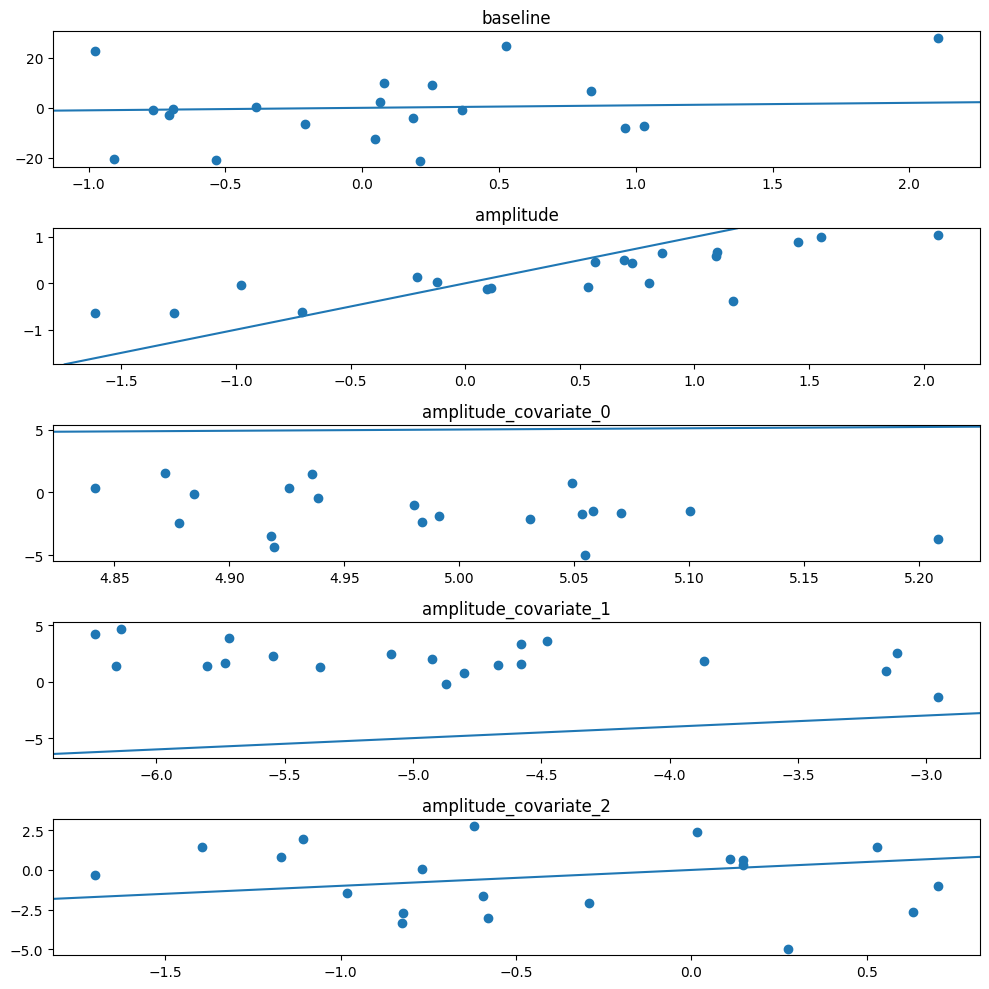

In [37]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10))

for ax, col in zip(ax.flatten(), parameters.columns[:5], strict=False):
    true_vals = parameters[col]
    est_vals = sgd_params[col]
    ax.scatter(true_vals, est_vals)
    ax.axline(xy1=(true_vals.min(), true_vals.min()), slope=1)
    ax.set_title(col)

fig.tight_layout()

The estimated parameters and model predictions look a bit better but are still off. We should adjust the architecture
of our model to fix this.

NB: If we remove the convolution with the impulse response, the estimation perfectly recovers the data-generating
parameters.